In [1]:
from IPython.display import display, Latex, Math, Markdown
import numpy as np
import sympy as sym
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
sym.init_printing()

def printltx(s):
    try:
        display(Latex(s))
    except:
        print(s)

def ltxmtx(A,axis=1):
    #print("pretty latex printing")
    try:
        if isinstance(A,list):
            A = np.array(A)        
        if isinstance(A,np.ndarray):
            A = A.round(4)            
        M  = sym.Matrix(A.tolist())
        sh = np.array(M.shape)
        sz = np.prod(sh)
        if sz == np.max(sh):
            if axis == 0:
                M=M.reshape(sz,1)
            else:
                M=M.reshape(1,sz)
        return " $"+sym.latex(M)+"$ "
    except:
        #print("Can not pretty latex print")
        return A

array_f = get_ipython().display_formatter.formatters['text/latex']
array_f.for_type('numpy.ndarray',ltxmtx)
array_f.for_type('sympy.matrices.dense.MutableDenseMatrix',ltxmtx)


In [2]:
from math import gcd
from functools import reduce

def initial_checks(P,phi):
    States = P.shape[0]
    printltx(r"Transition matrix is $P=$"+ltxmtx(P))
    printltx(r"Initial distribution $\phi=$"+ltxmtx(phi))    
    if phi.shape[0] != States:
        raise Exception("Transition matrix and initial distribution dimensions don't match")
    row_sums = np.sum(P,1)
    should_be = np.ones_like(row_sums)
    if np.allclose(row_sums,should_be) == False:
            raise Exception("Rows of transition matrix do not all sum to 1")
    return

def compute_absorbed_proportions(v,states_in_rec_classes=[]):
    if states_in_rec_classes == []:
        ap = [1.0]
    else:
        ap = [np.sum(v[states]) for states in states_in_rec_classes]
    return np.array(ap)

def plot_absorption(absorption_proportions,tol=0.001):
    absorption_proportions = np.array(absorption_proportions)
    absorbed_cumulative = np.sum(absorption_proportions,axis=1) #total absorbed by all recurrence classes
    absorbed_cumulative = absorbed_cumulative[absorbed_cumulative<1-tol] #Remove tail, if simulation continued to run after complete absorption
    absorbed_cumulative = np.append(absorbed_cumulative,1.0) #append 1.0 to end
    absorbed_marginal = np.diff(absorbed_cumulative) #find "newly" absorbed proportion at each step
    absorbed_marginal = np.insert(absorbed_marginal,0,absorbed_cumulative[0]) #np.diff shrinks array by 1 entry.  Prepend 0.0
    times = np.arange(absorbed_marginal.shape[0])
    printltx(r"Absorbed proportions (by recurrence class) "+ltxmtx(absorption_proportions[-1]))
    plt.bar(times,absorbed_marginal)
    plt.show()
    ave = absorbed_marginal.dot(times)
    printltx(r"Mean absorption time is "+str(ave))
    return

def simulate_samples(P,phi,Steps=500,Records=10,Samples=1000,states_in_rec_classes=[],tol=0.001):
    """
    Evolves the system by simulating many sample paths
    """
    States = P.shape[0]
    print("\n")
    printltx(r"Simulating "+str(Steps)+" steps with "+str(Samples)+" samples.")    
    epdf = np.zeros([Records,States],dtype=float)
    epdf[0,:] = phi[:]
    ap = compute_absorbed_proportions(phi,states_in_rec_classes)
    absorption_proportions = [ap]
    #There is a nuance here.  For epdf, we only keep the most Records distributions.
    #We really don't need to full prior history, so this help us conserve memory.
    #However we really DO need the full history of absorption_proportions, because
    #we want to plot the full distribution, over ALL time.
    #The problem is that we don't actually know how many steps it will take for complete
    #(or almost complete) absorption.  So, we cannot pre-allocate the size of 
    #absorption_propotions (coontrasts to epdf, where we can pre-allocate).
    #Therefore, we are stuck "growing the array" (as far as I can tell).
    #This raises the question - Is it better to grow the array using numpy.append
    #or list.append?  I am not certain.  The numpy.append command is very clear
    #that this makes a COPY each time, which may hurt performance.  I can not
    #tell if list.append also makes a new copy, or appends to the existing list.
    #I will use the list route here, but we be very happy if someone can definitively answer
    #this question.

    y = np.rint(phi*Samples).astype(int)
    Samples = np.sum(y)
    X = np.zeros([Records,Samples],dtype=int)
    X[0,:] = np.random.choice(States,Samples,p=phi)

    #for step in range(Steps):
    step = 0    
    while (step < Steps) | (np.sum(ap) < 1-tol):
        #Because we are not keeping the entire history, we loop repeatedly through the
        #same array, overwriting old states. We move down the rows of X until we hit
        #the bottom.  Then we jump back to the top and overwrite existing arrays.
        #The % operator does modular division and accomplishes the necessary looping.
        current_step = step%Records
        next_step = (step+1)%Records
        for samp in range(Samples):
            current_state = X[current_step,samp]
            r = np.random.rand()
            for next_state in range(States):
                r -= P[current_state,next_state]
                if r < 0:
                    X[next_step,samp] = next_state
                    break
        v = np.histogram(X[next_step,:],normed=True,bins=range(States+1))[0]
        epdf[next_step,:] = v
        ap = compute_absorbed_proportions(v,states_in_rec_classes)
        absorption_proportions.append(ap)
        step+=1
        
    #The last distribution is not necessarily on the bottom of epdf.  Next line fixes that.    
    epdf = np.roll(epdf,Records-next_step-1,axis=0)
    printltx(r"I did "+str(Steps)+" steps with "+str(Samples)+" samples.  The last "+str(Records)+" distributions are written as rows below.")    
    display(epdf)
    printltx(r"The average of these distributions is "+ltxmtx(np.mean(epdf,0)))
    plot_absorption(absorption_proportions,tol=tol)
    return 

def matrix_evolution(P,phi,Steps=500,Records=10,states_in_rec_classes=[],tol=0.001):
    """
    Evolves the system via matrix multiplication
    """
    States = P.shape[0]
    print("\n")
    printltx(r"Evolving "+str(Steps)+" steps via matrix multiplication.")
    tpdf = np.zeros([Records,States],dtype=float)
    tpdf[0,:] = phi[:]
    ap = compute_absorbed_proportions(phi,states_in_rec_classes)
    absorption_proportions = [ap]
    #see comments in corresponding position in simulate_samples
    
    #for step in range(Steps):
    step = 0    
    while (step < Steps) | (np.sum(ap) < 1-tol):
        current_step = step%Records
        next_step = (step+1)%Records
        tpdf[next_step,:] = tpdf[current_step,:].dot(P)

        ap = compute_absorbed_proportions(tpdf[next_step,:],states_in_rec_classes)
        absorption_proportions.append(ap)
        step+=1

    #The last distribution is not necessarily on the bottom of epdf.  Next line fixes that.    
    tpdf = np.roll(tpdf,Records-next_step-1,axis=0)
    printltx(r"I did "+str(Steps)+" steps.  The last "+str(Records)+" distributions are written as rows below.")
    display(tpdf)
    printltx(r"The average of these distributions is "+ltxmtx(np.mean(tpdf,0)))
    plot_absorption(absorption_proportions,tol=tol)
    return

def support(v):
    return np.nonzero(v)[0]    

def normalize_vec(v):
    tol = 0.001
    s = np.sum(v)
    if np.abs(s)<tol:
        s = v[support(v)][0] #if row sums to 0, divide by leftmost nonzero entry    
    return v/s

def normalize_rows(P):
    return np.apply_along_axis(normalize_vec,1,P)
    
def eigen_future(P,phi):
    """
    Long term behavior via eigenvectors and eigenvalues
    """
    States = P.shape[0]
    print("\n")
    printltx(r"Using eigenvectors and eigenvalues to find long term behavior.")
    (evals,LT) = np.linalg.eig(P.T)
    L = LT.T    
    
    #We'd like to sort things nicely.  First, we want to sort by eval length, largest first.
    #Then we'll break ties by real part, largest first
    #Then we'll break ties by imaginary part, largest first
    #Finally, we'll break ties by the smallest label on states in the support of the corresponding evec, smallest first.
    #This sort is basically optional - it just makes the results a bit easier to interpret.
    Len = np.abs(evals).round(4) #Must round, else evals of same true legnth may appear to be of different lengths    
    Re = np.real(evals).round(4)
    Im = np.imag(evals).round(4)    
    Fs = [States-support(v)[0] for v in L] #Gets the smallest label of states in the support of the evec.
    #We do use "States-___", because we will reverse everything below, but we want smallest first on this part.
    sort = np.lexsort([Fs,Im,Re,Len]) #sort priority goes right to left, for some reason
    sort = sort[::-1] #lexsort does ascending sort.  This changes to descending, as desired
    evals = evals[sort]
    L = L[sort]
    Len = Len[sort]
    Re = Re[sort]
    Im = Im[sort]
    
    L = normalize_rows(L)
    R = np.linalg.inv(L)
    D = np.diag(evals)
    printltx(r"left eigenvectors = rows of "+ltxmtx(L)+",  $\lambda =$"+ltxmtx(evals,0)+",  $| \lambda | =$"+ltxmtx(np.abs(evals),0))

    evals_live = evals.copy()
    evals_live[Len<1] = 0    
    vanish = L[Len<1]
    invar = L[Re>=1]
    persist = L[(Len>=1) & (Re<1)]
    
    num_rec_classes = invar.shape[0]
    states_in_rec_class = [support(pi).tolist() for pi in invar]
    persist_in_rec_class = [[] for r in invar]
    for (p,vec) in enumerate(persist):
        for cl,st in enumerate(states_in_rec_class):
            if set(support(vec)).issubset(set(st)):
                persist_in_rec_class[cl].append(p)
                break
    period_of_rec_class = [1+len(per) for per in persist_in_rec_class]

    recurrent_states = np.hstack(states_in_rec_class)
    all_states = set(range(States))    
    transient_states = all_states - set(recurrent_states)
    transient_states = np.array(sorted(transient_states),dtype=int)
    num_recurrent_states = len(recurrent_states)
    num_transient_states = len(transient_states)    

    for (cl,states) in enumerate(states_in_rec_class):
        period = period_of_rec_class[cl]
        print("\n\n")
        printltx(r"Recurrence Class "+str(cl))
        printltx(r"States = "+ltxmtx(states))        
        printltx("Period = "+str(period))
        printltx(r"The stationary/invariant distribution for this recurrence class is:")
        printltx(r"$\vec{\pi} = $"+ltxmtx(invar[cl]))
        if period > 1:
            printltx("Other persistent eigenvectors for this recurrence class are:")
            for per in persist_in_rec_class[cl]:
                printltx(r"$\vec{v} = $"+ltxmtx(persist[per]))    
    print("\n\n")
    printltx(r"Transient States")
    printltx(r"States "+ltxmtx(transient_states))
    if vanish.shape[0]>0:
        printltx(r"Vanishing eigenvectors are:")
        for v in vanish:
            printltx(r"$\vec{v} = $"+ltxmtx(v))

    if num_rec_classes == 1:
        period_of_chain = period_of_rec_class[0]
    else:
        gcd_periods = reduce(gcd,period_of_rec_class)
        period_of_chain = int(np.prod(period_of_rec_class)/gcd_periods)        
    
    pdf = np.zeros([period_of_chain,States])
    Dp = np.diag(evals_live)    
    for step in range(period_of_chain):
        pdf[step,:] = phi.dot(R).dot(Dp**(step+1)).dot(L)
    printltx(r"The analysis via eigenvectors says that, in the long run, this system should osciliate through the "+str(period_of_chain)+" distributions below.")
    display(pdf)
    printltx(r"The average of these distributions is "+ltxmtx(np.mean(pdf,0)))

    perm = np.hstack([recurrent_states,transient_states])    
    Pbar = P.copy()
    Pbar = Pbar[perm,:]
    Pbar = Pbar[:,perm]    
    
    R = Pbar[:num_recurrent_states:,:num_recurrent_states]
    S = Pbar[num_recurrent_states:,:num_recurrent_states]
    Q = Pbar[num_recurrent_states:,num_recurrent_states:]
    Z = Pbar[:num_recurrent_states,num_recurrent_states:]
    
    I = np.eye(Q.shape[0])
    M = np.linalg.inv(I-Q)
    WhenAbsorbed = np.sum(M,axis=1)
    WhereAbsorbed = M.dot(S)
    WhereAbsorbedContracted = np.zeros([num_transient_states,num_rec_classes])
    start = 0
    end = 0
    for (cl,states) in enumerate(states_in_rec_class):
        start = end
        end += len(states)
        WhereAbsorbedContracted[:,cl] = np.sum(WhereAbsorbed[:,start:end],axis=1)
    
    print("\n\n")
    printltx(r"Now we relabel the states so that recurrence classes are together and transient states are last.")
    printltx(r"Here is the relabelling "+ltxmtx(perm,0)+" $\mapsto$ "+ltxmtx(np.arange(States),0))
    printltx(r"This permutes the rows and columns of $P$ into $\bar{P}=$ "+ltxmtx(Pbar))
    printltx(r"The following top, left submatrix corresponds to recurrent $\to$ recurrent transitions $R=$ "+ltxmtx(R))
    printltx(r"The following bottom, left submatrix corresponds to transient $\to$ recurrent transitions $S=$ "+ltxmtx(S))
    printltx(r"The following bottom, right submatrix corresponds to transient $\to$ transient transitions $Q=$ "+ltxmtx(Q))
    printltx(r"The following top, right submatrix corresponds to recurrent $\to$ transient transitions $Z=$ "+ltxmtx(Z))
    printltx(r"The matrix directly above had better contain all zeros.")
    printltx(r"As stated in Lawler, we compute $M=(I-Q)^{-1}=$ "+ltxmtx(M))
    printltx(r"The $(i,j)$ entry of $M$ is the expected number of visits to state $j+"+str(num_recurrent_states)+"$ (transient) if chain starts at state $i+"+str(num_recurrent_states)+"$ (transient).")
    printltx(r"So the sum across row $i$ is the expected absorption time if chain starts at state $i$")
    printltx(r"I compute these expected absorption times to be "+ltxmtx(WhenAbsorbed,0))
    printltx(r"Now, for absorption probabilities.  As stated in Lawler, the $(i,j)$ entry of $MS$ is the probability of absorption at state $j$ (recurrent) if chain starts at state $i+"+str(num_recurrent_states)+"$ (transient).")
    printltx(r"I compute these absorption probabilities to be "+ltxmtx(WhereAbsorbed))
    printltx(r"If we contract recurrent classes, this becomes"+ltxmtx(WhereAbsorbedContracted))
    printltx(r"Where the $(i,j)$ entry is the probability of absorption into recurrence class $j$ if chain starts if chain starts at state $i+"+str(num_recurrent_states)+"$ (transient).")
    return 

In [ ]:
P = np.array([[0,0,0,1,0,0,0],
              [0,0,1,1,0,1,1],
              [0,0,0,0,1,0,0],
              [1,0,0,0,0,0,0],
              [0,0,0,0,0,1,0],
              [0,0,1,0,0,0,0],
              [1,1,0,0,0,0,0]
              ])
P = np.array([[0,1,0,1,0,0,0,0,0],
              [1,0,1,0,1,0,0,0,0],
              [0,1,0,0,0,1,0,0,0],
              [1,0,0,0,1,0,1,0,0],
              [0,1,0,1,0,1,0,1,0],
              [0,0,1,0,1,0,0,0,1],
              [0,0,0,0,0,0,1,0,0],
              [0,0,0,0,1,0,1,0,1],
              [0,0,0,0,0,0,0,0,1]
              ])
P = normalize_rows(P)
States = P.shape[0]
phi = np.zeros([States])
phi[0] = 1
Steps = 500 #total number of steps to take
Records = 10 #To manage memory, we don't keep the entire history of the system.  We keep
#the most recent "Records" states.
Samples = 1000
tol = 0.0001
states_in_rec_classes = [[0,3],[2,4,5]]

initial_checks(P,phi)
simulate_samples(P,phi,Steps=Steps,Records=Records,states_in_rec_classes=states_in_rec_classes,tol=tol,Samples=Samples)
matrix_evolution(P,phi,Steps=Steps,Records=Records,states_in_rec_classes=states_in_rec_classes,tol=tol)
eigen_future(P,phi)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



Doing absorbing boundary condition


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.2962,  0.    ,  0.    ,  0.    ,  0.7038],
       [ 0.2962,  0.    ,  0.    ,  0.    ,  0.7038],
       [ 0.2962,  0.    ,  0.    ,  0.    ,  0.7038],
       [ 0.2962,  0.    ,  0.    ,  0.    ,  0.7038],
       [ 0.2962,  0.    ,  0.    ,  0.    ,  0.7038],
       [ 0.2962,  0.    ,  0.    ,  0.    ,  0.7038],
       [ 0.2962,  0.    ,  0.    ,  0.    ,  0.7038],
       [ 0.2962,  0.    ,  0.    ,  0.    ,  0.7038],
       [ 0.2962,  0.    ,  0.    ,  0.    ,  0.7038],
       [ 0.2962,  0.    ,  0.    ,  0.    ,  0.7038]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

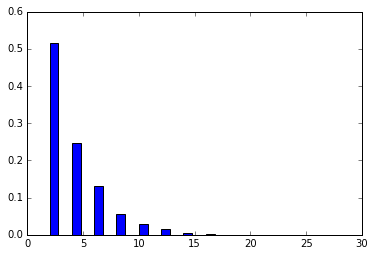

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[  3.07692308e-01,   3.20747403e-79,   0.00000000e+00,
          4.81121104e-79,   6.92307692e-01],
       [  3.07692308e-01,   0.00000000e+00,   3.84896883e-79,
          0.00000000e+00,   6.92307692e-01],
       [  3.07692308e-01,   1.53958753e-79,   0.00000000e+00,
          2.30938130e-79,   6.92307692e-01],
       [  3.07692308e-01,   0.00000000e+00,   1.84750504e-79,
          0.00000000e+00,   6.92307692e-01],
       [  3.07692308e-01,   7.39002016e-80,   0.00000000e+00,
          1.10850302e-79,   6.92307692e-01],
       [  3.07692308e-01,   0.00000000e+00,   8.86802419e-80,
          0.00000000e+00,   6.92307692e-01],
       [  3.07692308e-01,   3.54720968e-80,   0.00000000e+00,
          5.32081451e-80,   6.92307692e-01],
       [  3.07692308e-01,   0.00000000e+00,   4.25665161e-80,
          0.00000000e+00,   6.92307692e-01],
       [  3.07692308e-01,   1.70266064e-80,   0.00000000e+00,
          2.55399097e-80,   6.92307692e-01],
       [  3.07692308e-01,   0.0000000

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

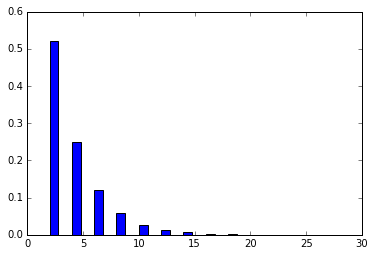

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.30769231,  0.        ,  0.        ,  0.        ,  0.69230769]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



Doing reflecting boundary condition


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.    ,  0.3058,  0.    ,  0.6942,  0.    ],
       [ 0.1248,  0.    ,  0.4622,  0.    ,  0.413 ],
       [ 0.    ,  0.2974,  0.    ,  0.7026,  0.    ],
       [ 0.1204,  0.    ,  0.453 ,  0.    ,  0.4266],
       [ 0.    ,  0.2942,  0.    ,  0.7058,  0.    ],
       [ 0.1096,  0.    ,  0.471 ,  0.    ,  0.4194],
       [ 0.    ,  0.2892,  0.    ,  0.7108,  0.    ],
       [ 0.1214,  0.    ,  0.4552,  0.    ,  0.4234],
       [ 0.    ,  0.3016,  0.    ,  0.6984,  0.    ],
       [ 0.116 ,  0.    ,  0.4628,  0.    ,  0.4212]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

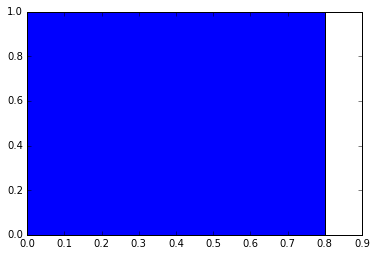

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.        ,  0.30769231,  0.        ,  0.69230769,  0.        ],
       [ 0.12307692,  0.        ,  0.46153846,  0.        ,  0.41538462],
       [ 0.        ,  0.30769231,  0.        ,  0.69230769,  0.        ],
       [ 0.12307692,  0.        ,  0.46153846,  0.        ,  0.41538462],
       [ 0.        ,  0.30769231,  0.        ,  0.69230769,  0.        ],
       [ 0.12307692,  0.        ,  0.46153846,  0.        ,  0.41538462],
       [ 0.        ,  0.30769231,  0.        ,  0.69230769,  0.        ],
       [ 0.12307692,  0.        ,  0.46153846,  0.        ,  0.41538462],
       [ 0.        ,  0.30769231,  0.        ,  0.69230769,  0.        ],
       [ 0.12307692,  0.        ,  0.46153846,  0.        ,  0.41538462]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

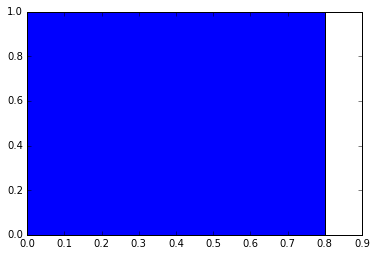

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ -1.66533454e-16,   3.07692308e-01,  -7.60262579e-16,
          6.92307692e-01,  -7.49800862e-17],
       [  1.23076923e-01,  -5.59861986e-16,   4.61538462e-01,
         -7.62330904e-16,   4.15384615e-01]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>



Doing semi boundary condition


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.078 ,  0.1152,  0.1776,  0.2434,  0.3858],
       [ 0.0796,  0.1156,  0.1648,  0.2584,  0.3816],
       [ 0.0764,  0.1178,  0.1708,  0.2474,  0.3876],
       [ 0.0842,  0.1132,  0.1706,  0.2544,  0.3776],
       [ 0.082 ,  0.1192,  0.168 ,  0.2572,  0.3736],
       [ 0.0784,  0.1188,  0.1774,  0.2474,  0.378 ],
       [ 0.0764,  0.121 ,  0.1714,  0.2554,  0.3758],
       [ 0.081 ,  0.1084,  0.1786,  0.2548,  0.3772],
       [ 0.0764,  0.1226,  0.1712,  0.2516,  0.3782],
       [ 0.08  ,  0.1146,  0.1682,  0.2534,  0.3838]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

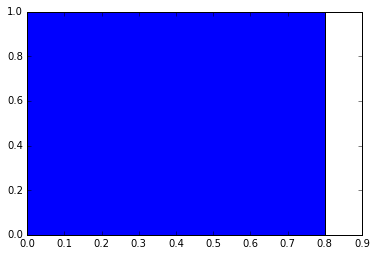

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.07582938,  0.11374408,  0.17061611,  0.25592417,  0.38388626],
       [ 0.07582938,  0.11374408,  0.17061611,  0.25592417,  0.38388626],
       [ 0.07582938,  0.11374408,  0.17061611,  0.25592417,  0.38388626],
       [ 0.07582938,  0.11374408,  0.17061611,  0.25592417,  0.38388626],
       [ 0.07582938,  0.11374408,  0.17061611,  0.25592417,  0.38388626],
       [ 0.07582938,  0.11374408,  0.17061611,  0.25592417,  0.38388626],
       [ 0.07582938,  0.11374408,  0.17061611,  0.25592417,  0.38388626],
       [ 0.07582938,  0.11374408,  0.17061611,  0.25592417,  0.38388626],
       [ 0.07582938,  0.11374408,  0.17061611,  0.25592417,  0.38388626],
       [ 0.07582938,  0.11374408,  0.17061611,  0.25592417,  0.38388626]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

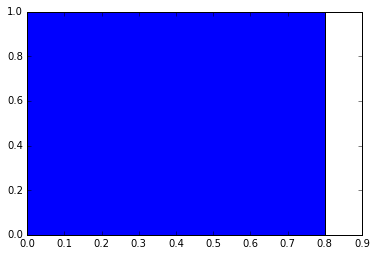

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.07582938,  0.11374408,  0.17061611,  0.25592417,  0.38388626]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [4]:
#Random walk on {0,1,2,...,States-1}
p = 0.6
q = 1 - p
boundary = "absorbing"
States = 5
phi = np.zeros([States])
phi[round((States-1)/2)] = 1
#phi[1] = 1
#phi = np.ones(5)/5
Steps = 500 #total number of steps to take
Records = 10
Samples = 5000


def make_P_for_random_walk(p,q,States,boundary):
    if q > 1-p:
        q = 1-p
    r = 1-p-q
    
    P = np.zeros([States,States])
    for i in range(1,States-1):
        P[i,i-1]=q
        P[i,i]=r
        P[i,i+1]=p

    if boundary == "absorbing":
        P[0,0] = 1
        P[-1,-1] = 1
    elif boundary == "reflecting":
        P[0,1] = 1
        P[-1,-2] = 1
    elif boundary == "semi":
        P[0,0] = q+r
        P[0,1] = p
        P[-1,-2] = q
        P[-1,-1] = p+r
    else:
        raise Exception("Invalid boundary condition")
    return P

boundary = "absorbing"
print("\n\nDoing "+boundary+" boundary condition")
P = make_P_for_random_walk(p,q,States,boundary)
states_in_rec_classes = [[0],[States-1]]
initial_checks(P,phi)
simulate_samples(P,phi,Steps=Steps,Records=Records,states_in_rec_classes=states_in_rec_classes,tol=tol,Samples=Samples)
matrix_evolution(P,phi,Steps=Steps,Records=Records,states_in_rec_classes=states_in_rec_classes,tol=tol)
eigen_future(P,phi)



boundary = "reflecting"
print("\n\nDoing "+boundary+" boundary condition")
P = make_P_for_random_walk(p,q,States,boundary)
states_in_rec_classes = range(States)
initial_checks(P,phi)
simulate_samples(P,phi,Steps=Steps,Records=Records,states_in_rec_classes=states_in_rec_classes,tol=tol,Samples=Samples)
matrix_evolution(P,phi,Steps=Steps,Records=Records,states_in_rec_classes=states_in_rec_classes,tol=tol)
eigen_future(P,phi)


boundary = "semi"
print("\n\nDoing "+boundary+" boundary condition")
P = make_P_for_random_walk(p,q,States,boundary)
states_in_rec_classes = range(States)
initial_checks(P,phi)
simulate_samples(P,phi,Steps=Steps,Records=Records,states_in_rec_classes=states_in_rec_classes,tol=tol,Samples=Samples)
matrix_evolution(P,phi,Steps=Steps,Records=Records,states_in_rec_classes=states_in_rec_classes,tol=tol)
eigen_future(P,phi)

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.36873747,  0.31663327,  0.31462926],
       [ 0.38877756,  0.26853707,  0.34268537],
       [ 0.36673347,  0.27254509,  0.36072144],
       [ 0.35270541,  0.28056112,  0.36673347],
       [ 0.38476954,  0.26452906,  0.3507014 ],
       [ 0.35671343,  0.28857715,  0.35470942],
       [ 0.36873747,  0.3246493 ,  0.30661323],
       [ 0.36472946,  0.28456914,  0.3507014 ],
       [ 0.38476954,  0.28456914,  0.33066132],
       [ 0.35871743,  0.29859719,  0.34268537]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

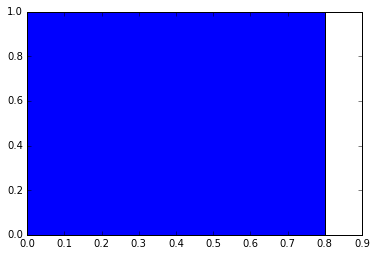

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

array([[ 0.36842105,  0.28070175,  0.35087719],
       [ 0.36842105,  0.28070175,  0.35087719],
       [ 0.36842105,  0.28070175,  0.35087719],
       [ 0.36842105,  0.28070175,  0.35087719],
       [ 0.36842105,  0.28070175,  0.35087719],
       [ 0.36842105,  0.28070175,  0.35087719],
       [ 0.36842105,  0.28070175,  0.35087719],
       [ 0.36842105,  0.28070175,  0.35087719],
       [ 0.36842105,  0.28070175,  0.35087719],
       [ 0.36842105,  0.28070175,  0.35087719]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

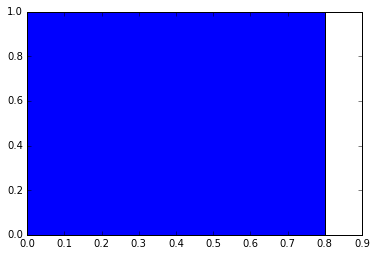

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

C:\Users\scook\AppData\Local\Continuum\Anaconda3\lib\site-packages\ipykernel\__main__.py:230: ComplexWarning: Casting complex values to real discards the imaginary part


<IPython.core.display.Latex object>

array([[ 0.36842105,  0.28070175,  0.35087719]])

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [5]:
P = np.array([[1/3,1/3,1/3],[1/4,1/4,1/2],[1/2,1/4,1/4]])
phi = np.array([1/8,1/4,5/8])
Steps = 500 #total number of steps to take
Records = 10 #To manage memory, we don't keep the entire history of the system.  We keep
#the most recent "Records" states.
Samples = 500

initial_checks(P,phi)       
simulate_samples(P,phi,Steps,Records,Samples)
matrix_evolution(P,phi,Steps,Records)
eigen_future(P,phi)

There are actually two ways to find the left eigenvectors.  Both use np.linalg.eig which gives right eigenvectors.
- do eig on $P$ to get $(D,R)$.  The rows of $R^{-1}$ are left evecs
- do eig on $P^T$ to get $(DT,RT)$.   The rows of $RT^T$ are left evecs

However, you do not get excactly the same left eigenvectors from these methods - they differ by scalar multiples.  This is not a problem, but it might make you skeptical.  The function normalize_rows scalar adjusts the original eigenvectors so we can see that that these two methods do actually agree.